In [ ]:
!pip install -U langchain-openai

In [2]:
import pandas as pd
import numpy as np
import time
import pathlib
import os
import re

from langchain_core.documents import Document
from langchain_core.retrievers import BaseRetriever
from langchain_core.callbacks import CallbackManagerForRetrieverRun
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.llms import OpenAI
from langchain.chains import RetrievalQA, RetrievalQAWithSourcesChain
from langchain.document_loaders import TextLoader
from langchain.document_loaders import DirectoryLoader
from langchain.chat_models import ChatOpenAI
from langchain.docstore.document import Document
from langchain.prompts import PromptTemplate
from langchain_openai import ChatOpenAI

from langchain_openai import OpenAIEmbeddings

from typing import List
from dotenv import load_dotenv

from langchain.vectorstores import Chroma

# Load environment variables

In [18]:
path_env = pathlib.Path('/export/usuarios_ml4ds/cggamella/NP-Search-Tool/.env')

load_dotenv(path_env)
api_key = os.getenv("OPENAI_API_KEY")

os.environ["OPENAI_API_KEY"] = api_key

## Create VectorDB with parquet docs

In [ ]:
# Se ha probado con outsiders (pero el objetivo será usarlos con las licitaciones completas de BSC)
path = '/export/usuarios_ml4ds/cggamella/NP-Company-Process/data/DESCARGAS_ENTREGABLES/outsiders.parquet'
df_out = pd.read_parquet(path)

def unify_colname(col):
    return ".".join([el for el in col if el])

df_out.columns = [unify_colname(col) for col in df_out.columns]

index_names = df_out.index.names
#Se resetea el índice sobre el propio dataframe
df_out.reset_index(inplace=True)
#Crear identifier con los index_names separados con '/', así generamos un id único para cada fila
df_out["identifier"] = df_out[index_names].astype(str).agg("/".join, axis=1)
#Filtrado para quedarme con esas 2 cols
df_out = df_out[['identifier', 'title']]

# Normalizar el campo textual para evitar problemas
df_out['title'] = df_out['title'].str.lower()

In [ ]:
# Crear el text splitter, [chunk_size: #caracteres de cada chunk];
#[chunk_overlap: #caracteres solapan entre chunks para no perder info.]
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)

# Crear una lista para almacenar los documentos
documents = []
# Procesar cada fila como un documento separado
for idx, row in df_out.iterrows():
    example_document = row['title']
    #print("el example doc es:",example_document)
    doc = Document(page_content=example_document, metadata={"url": "local", "source": "initial", "identifier": row['identifier']})
    #print("El doc es:",doc)
    # Dividir el documento en fragmentos
    chunks = text_splitter.split_text(doc.page_content)
    #print("Los chunks son:",chunks)
    for chunk in chunks:
        chunk_doc = Document(page_content=chunk, metadata=doc.metadata)
        #print("EL chunk_doc es:\n",chunk_doc)
        documents.append(chunk_doc)

# Crear bbdd vectorial con Chroma y guardar embeddings

In [118]:
# Embed and store the texts
path_to_index = '/export/usuarios_ml4ds/cggamella/NP-Search-Tool/aux_scripts/RAG'
# Supplying a persist_directory will store the embeddings on disk
persist_directory = (pathlib.Path(path_to_index) / 'db1').as_posix()

In [119]:
start = time.time()

# Define embeddings
embeddings = OpenAIEmbeddings()

# Almacenar los fragmentos en una base de datos vectorial usando Chroma
# Se extrae el contenido (page_content).El contenido se pasa a OpenAIEmbeddings
# para obtener los embeddings. El vector resultante se almacena en la base de datos junto con los metadatos(índices).
vectordb = Chroma.from_documents(
    documents=documents,
    embedding=embeddings,
    persist_directory=persist_directory 
)

# Tiempo total de ejecución, tarda 51 mins en 300k docs
end = time.time()
print(f"Total time is {end - start} seconds")

Total time is 2886.445102930069 seconds


In [120]:
#Hay que hacerlo para guardar de manera persistente en el disco, SOLO EN NOTEBOOKS, en scripts no es necesario.
vectordb.persist()
vectordb = None

/home/cggamella/.local/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: Since Chroma 0.4.x the manual persistence method is no longer supported as docs are automatically persisted.
  warn_deprecated(


In [121]:
#Cargar la bbdd vectorial de Chroma(ya creada) que contiene docs, embeddings y metadatos 'identifier'
vectordb = Chroma(persist_directory=persist_directory)

In [122]:
results = vectordb.get(limit=6, include=['documents', 'embeddings', 'metadatas'])

In [123]:
results

{'ids': ['00007b08-f57c-435d-9038-2956ad47f807',
  '0000816e-ff3b-4b9b-9de9-c2507411cd4c',
  '0000cc4a-11a2-4d54-961e-eda7e2174e4f',
  '0000f9d6-b683-4054-b19e-f9bbda23fd4e',
  '00011233-0d1a-4d79-b01a-5778bf9676db',
  '00011399-df46-4f5f-9cab-00a3bb8b440b'],
 'embeddings': [[-0.011149450205266476,
   -0.014979518949985504,
   -0.0063993483781814575,
   -0.008593800477683544,
   -0.0053021227940917015,
   0.010692841373383999,
   -0.014829587191343307,
   0.003479091916233301,
   -0.006331197917461395,
   -0.014829587191343307,
   -0.014543354511260986,
   -0.0036665063817054033,
   -0.008723286911845207,
   -0.01960013434290886,
   -0.022312531247735023,
   -0.012362532317638397,
   -0.005779177416115999,
   -0.0014209415530785918,
   0.02330753207206726,
   0.010999519377946854,
   -0.020526982843875885,
   -0.009084485471248627,
   0.00047066560364328325,
   -0.039581913501024246,
   -0.0022200082894414663,
   -0.01774643547832966,
   0.016206230968236923,
   -0.020526982843875885,


# Retriever personalizado

In [9]:
'''
class AcronymAwareRetriever(BaseRetriever):
    """
    Retriever personalizado para buscar documentos que contienen un acrónimo específico.
    """
    documents: List[Document]
    k: int

    def _get_relevant_documents(
        self, acronym: str, *, run_manager: CallbackManagerForRetrieverRun = None
    ) -> List[Document]:
        """
        Recupera documentos que contienen el acrónimo proporcionado.
        """
        matching_documents = []
        pattern = re.compile(r'\b{}\b'.format(re.escape(acronym)), re.IGNORECASE)

        for document in self.documents:
            if len(matching_documents) >= self.k:
                break
            if pattern.search(document.page_content):
                matching_documents.append(document)
        
        return matching_documents
'''

In [28]:
class AcronymAwareRetriever(BaseRetriever):
    """
    Custom retriever for searching documents containing a specific acronym.
    """
    vectorstore: Chroma
    k: int

    def _get_relevant_documents(
        self, acronym: str, *, run_manager: CallbackManagerForRetrieverRun = None
    ) -> List[str]:
        """
        Retrieve documents containing the provided acronym by directly querying
        the vector database.
        """
        # Utilizar la bbdd vectorial para buscar documentos que contengan el acrónimo
        search_query = {"$contains": acronym}
        results = self.vectorstore.get(where_document=search_query, limit=self.k)
        #Devuelve diccionario con metadatas, y selecciono la info de los documentos
        documents = results['documents']

        return documents

In [29]:
acronym_retriever = AcronymAwareRetriever(vectorstore=vectordb, k=5)
result_docs = acronym_retriever._get_relevant_documents("ghz")

# Imprimir cada documento
for doc in result_docs:
    print(doc)
    print('*'*100)

el procesador alcanza velocidades de procesamiento de hasta 4 ghz, garantizando eficiencia.
****************************************************************************************************


In [30]:
# Tu prompt_template
prompt_template_text = """
Given the following {summaries}. These documents are related or have the context to understand the following task:
Given the word "{acronym}", understand that an acronym word is a type of abbreviation formed by taking the initial
letters or parts of words from a phrase or term and combining them to form a new word, that is what we call expanded_word.
And after reading the previous documents I sent you, where spaces between words are replaced by underscores '_'.
If the expanded word is too long or if there is any other issue, do NOT provide any answer. 
--------------------
Please give me your answer in the format 'acronym_word:expanded_word'.
For example, for the following acronyms, "aeat" stands for "agencia_estatal_de_administración_tributaria", the answer must be: aeat:agencia_estatal_de_administración_tributaria 
"""
prompt_template = PromptTemplate.from_template(template=prompt_template_text)

In [31]:
# Set up the turbo LLM
llm = ChatOpenAI(
    temperature=0.2,
    model_name='gpt-4o'
)
# Crear el retriever personalizado con una lista de documentos
acronym_retriever = AcronymAwareRetriever(vectorstore=vectordb, k=3)

# Crear la chain
chain = RetrievalQAWithSourcesChain.from_chain_type(
    llm=llm,
    retriever=acronym_retriever,
    chain_type="stuff",
    verbose=True,
    chain_type_kwargs={
        "verbose": True,
        "prompt": prompt_template,
    }
)

In [32]:
def generate_acronym_expansions(chain, acronyms):
    results = {}
    for acronym in acronyms:
        # Recuperar documentos relevantes utilizando el retriever
        summaries = chain.retriever.get_relevant_documents(acronym)
        print("Los RETRIEVED DOCS SON:\n", summaries)
        # Formar el prompt utilizando el template
        prompt = prompt_template.format(acronym=acronym, summaries=summaries)
        # Ejecutar la cadena con el prompt usando invoke
        response = chain.invoke({"question": prompt, "acronym": acronym, "summaries": summaries})
        print(f"Respuesta del modelo para '{acronym}':\n{response}\n")
        # Obtener la respuesta del modelo de lenguaje
        answer = response['answer']
        print(f"LA ANSWER ES:\n",answer)
        # Parsear la respuesta y agregarla a los resultados
        results[acronym] = answer.strip()
    return results

In [182]:
# Lista de acrónimos a buscar
acronyms = ['ghz','ecc','vga','s.l', 's.a.', 'bop', 'pcap', 'ceip', 'jjmm', 'smp', 'avda', 'ffcc', 'itv']

# Generar las expansiones de los acrónimos
acronym_expansions = generate_acronym_expansions(chain, acronyms)

Los RETRIEVED DOCS SON:
 ["l'objecte del contracte és l'adquisició d'un perfilador vertical doppler (radar meteorològic) de banda k (24 ghz) per a l'estudi de perfils de precipitació atmosfèrica amb elevada resolució espacial i temporal (1 minut i 50 m respectivament), model mrr-pro del fabricant metek.\n\naquest equip permet als investigadors realitzar els estudis descrits al projecte ondas de gravedad, precipitacion orográfica y procesos asociados en áreas de montaña contemplat a la sol·licitud de pròrroga del projecte de recerca concedit pel ministerio de economía y competitividad amb número de referència cgl2015-65627-c3-2-r (mineco/feder).", "subministrament d'un generador vectorial de 20 ghz amb modulacio i/q de 2 ghz d'ample de banda i 2g mostres de memòria per al departament de teoria del senyal i comunicacions de la upc.", 'servei de manteniment preventiu de l’equip de rmn bruker avance neo d’1 ghz en els termes establerts al plec de prestacions tècniques.\nl’equip objecte de 


> Finished chain.

> Finished chain.

> Finished chain.
Respuesta del modelo para 'ecc':
{'question': '\nGiven the following ["transmissió onerosa i constitució d\'un dret de superfície sobre la finca municipal situada a l\'avigunda sitges 13 cantonada amb carrer camp dels prats núm. 11-15 per a destinar-la a la promoció, construcció i posterior gestió d\'habitatges de protecció oficial en règim de lloguer assequible.", "1.\\tl\'objecte del contracte és el servei de neteja i desinfecció interior de contenidors de càrrega posterior de les fraccions de paper-cartró, vidre, envasos, orgànica i resta amb capacitats que van des dels 120 litres fins a 1.100 litres.\\n\\nen el plec de prescripcions tècniques, en endavant ppt, es defineixen les tasques a realitzar en el servei, tipus i quantitats de contenidors objecte del contracte, freqüència del servei, horaris, característiques dels vehicles, característiques dels accessoris, mitjans materials i humans a emprar.\\n\\n2.\\tles especificaci

Los RETRIEVED DOCS SON:
 ['suministro de ambisome 50 mg., medicamentos de distribución exclusiva de la firma "gilead sciences s.l.” para el tratamiento de pacientes con neutropenia grave con destino al servicio de farmacia, del hospital universitario 12 de octubre.', 'suministro medicamentos exclusivos teva pharma s.l.u. a adjudicar por procedimiento negociado sin publicidad. pnsp-sum 035/21', 'suministro de medicamentos de distribución exclusiva de la firma orphan europe s.l., con destino al servicio de farmacia del hospital universitario 12 de octubre']


> Entering new RetrievalQAWithSourcesChain chain...


> Entering new StuffDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:

Given the following . These documents are related or have the context to understand the following task:
Given the word "s.l", understand that an acronym word is a type of abbreviation formed by taking the initial
letters or parts of words from a phrase or term and combining th



> Entering new StuffDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:

Given the following . These documents are related or have the context to understand the following task:
Given the word "bop", understand that an acronym word is a type of abbreviation formed by taking the initial
letters or parts of words from a phrase or term and combining them to form a new word, that is what we call expanded_word.
And after reading the previous documents I sent you, where spaces between words are replaced by underscores '_'.
If the expanded word is too long or if there is any other issue, do NOT provide any answer. 
--------------------
Please give me your answer in the format 'acronym_word:expanded_word'.
For example, for the following acronyms, "aeat" stands for "agencia_estatal_de_administración_tributaria", the answer must be: aeat:agencia_estatal_de_administración_tributaria 


> Finished chain.

> Finished chain.

> Finished chain.
Respuesta del modelo pa


> Finished chain.

> Finished chain.

> Finished chain.
Respuesta del modelo para 'pcap':
{'question': '\nGiven the following ["l\'objecte del contracte és la prestació del servei de transport adaptat per a persones amb discapacitat des del baix empordà a centres de serveis socials d\'altres comarques, en concret, dos rutes (anada i tornada) que s\'indiquen a l\'annex 1 del pcap.", \'constitueix l’objecte d’aquest contracte el subministrament i instal·lació d’aire condicionat als espais comuns de la residència i centre de dia montsacopa per garantir una temperatura òptima de confort en períodes de calor. (veure clàusula 1 del pcap)\', "realització d\'una enquesta telefònica a una mostra de 1.500 i amb una durada màxima de 20 minuts en les condicions que es determinen en el document de concreció de condicions (cc) i en el pcap i pptp de l\'acord marc de serveis per a la realització d\'estudis d\'opinió d\'interès de la generalitat (ceo-2021-17). lot 2 de l\'acord marc."]. These documen

Los RETRIEVED DOCS SON:
 ["equip per la mesura i monitorització de senyals de vídeo i audio sobre ip amb l'estàndard smpte 2110, senyal de temps ptp i vídeo sdi-4k", "serveis per l'assessorament, el desenvolupament i l'execució del social media plan (en endavant smp) i més concretament de la gestió de les xarxes socials de catalunya experience pel mercat que correspongui segons el lot:\n-\tlot 1: frança\n-\tlot 2: gran bretanya i irlanda\n-\tlot 3: europa central\n-\tlot 4: països baixos i bèlgica\n-\tlot 5: itàlia \n-\tlot 6: rússia i països de l'est\n-\tlot 7: estats units i canadà\n-\tlot 8: brasil i argentina\n-\tlot 9: àsia - pacific, excepte xina\n-\tlot 10: xina\n-        lot 11: pirineus", "serveis per l'assessorament, el desenvolupament i l'execució del social media plan (en endavant smp) i més concretament de la gestió de les xarxes socials de catalunya experience pel mercat que correspongui segons el lot.\n\nl'objecte del contracte es divideix en els lots següents: \n- lot 1

Los RETRIEVED DOCS SON:
 ['contratación del mantenimiento preventivo, correctivo, evolutivo y proactivo de sistemas de peaje de euskotren en el ferrocarril (ffcc), funicular y en tranvías', 'mantenimiento de los equipos del sistema de peaje de euskotren en el ffcc y el tranvía de bilbao', 'urbanización parcial de la acera de los números impares de la avda. cataluña entre ffcc a huesca y la c/ rio ara']


> Entering new RetrievalQAWithSourcesChain chain...


> Entering new StuffDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:

Given the following . These documents are related or have the context to understand the following task:
Given the word "ffcc", understand that an acronym word is a type of abbreviation formed by taking the initial
letters or parts of words from a phrase or term and combining them to form a new word, that is what we call expanded_word.
And after reading the previous documents I sent you, where spaces between words are replaced by 

In [183]:
acronym_expansions

{'ghz': 'ghz:gigahertz',
 'ecc': 'ecc:electronic_control_center',
 'vga': 'vga:video_graphics_array',
 's.l': 's.l:sociedad_limitada',
 's.a.': 'Sure, please provide the acronyms you need expanded.',
 'bop': 'bop:business_operations_plan',
 'pcap': 'pcap:packet_capture',
 'ceip': 'ceip:centro_de_educación_infantil_y_primaria',
 'jjmm': 'I\'m sorry, but based on the information provided, I cannot determine an appropriate expanded word for the acronym "jjmm".',
 'smp': 'smp:symmetric_multiprocessing',
 'avda': 'avda:avenida',
 'ffcc': 'ffcc:ferrocarriles',
 'itv': 'itv:inspección_técnica_de_vehículos'}

# NP-Search-Tool sacar acrónimos con RAG

In [ ]:
#!pip install chromadb
#!pip install -U langchain-openai

In [54]:
from langchain.vectorstores import Chroma
from langchain.embeddings import OpenAIEmbeddings
from langchain.llms import OpenAI
from sentence_transformers import SentenceTransformer
import re

In [55]:
path = '/export/usuarios_ml4ds/cggamella/NP-Company-Process/data/DESCARGAS_ENTREGABLES/outsiders.parquet'
df_out = pd.read_parquet(path)

In [56]:
def unify_colname(col):
    return ".".join([el for el in col if el])

In [57]:
df_out.columns = [unify_colname(col) for col in df_out.columns]

In [58]:
#Para coger ['zip', 'file name', 'entry']
index_names = df_out.index.names
#Se resetea el índice sobre el propio dataframe
df_out.reset_index(inplace=True)
#Pone como identifier los index names separados con '/', así generamos un id único para cada fila
df_out["identifier"] = df_out[index_names].astype(str).agg("/".join, axis=1)

In [59]:
df_filtered = df_out.loc[:100, ['identifier', 'title']]

In [60]:
# Calcular la longitud media de la columna 'title'
df_filtered['title_length'] = df_filtered['title'].apply(len)
average_length = df_filtered['title_length'].mean()
average_length

151.6039603960396

In [61]:
# Inicializar el modelo de embeddings
model = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2', device='cuda')
# Generar embeddings para cada título en el dataframe
embeddings = model.encode(df_out['title'].tolist())

In [62]:
def retrieve_context_similarity(acronym, embeddings, df_out):
    acronym_embedding = model.encode([acronym])
    #print("La query embedding es:\n", query_embedding)
    similarities = cosine_similarity(acronym_embedding, embeddings)[0]
    print("Las cosine similarities son:\n", similarities)
    most_similar_indices = np.argsort(similarities)[-10:][::-1]
    print("Los indices mas similares son:\n", most_similar_indices)
    results = [df_out['title'].iloc[i] for i in most_similar_indices]
    print("Los resultados del retrieve son:\n", results)
    return results

In [63]:
def retrieve_context_contain_acronym(acronym, df_out):
    # Crear el patrón de expresión regular para coincidir con la palabra exacta
    pattern = re.compile(r'\b' + re.escape(acronym) + r'\b', re.IGNORECASE)
    # Filtrar los títulos que contienen el acrónimo exacto
    results = df_out[df_out['title'].str.contains(pattern, na=False)]
    # Obtener los títulos y limitar a los primeros 5 documentos
    titles = results['title'].head(5).tolist()
    # Limitar cada título a los primeros 70 caracteres
    limited_titles = [title[:70] for title in titles]
    return limited_titles

In [69]:
def retrieve_context_contain_acronym_improved(acronym, df_out):
    # Crear el patrón de expresión regular para coincidir con la palabra exacta
    pattern = re.compile(r'\b' + re.escape(acronym) + r'\b', re.IGNORECASE)
    contexts = []
    
    # Iterar sobre cada título en el DataFrame
    for title in df_out['title']:
        if pd.isna(title):
            continue
        # Buscar todas las coincidencias del patrón en el título
        for match in re.finditer(pattern, title):
            # Asegurarse de no ir más allá del comienzo del texto
            start = max(match.start() - 70, 0)  
            end = match.end() + 70  
            # Extraer el contexto alrededor del acrónimo
            context = title[start:end]
            contexts.append(context)
            # Limitar a los primeros 5 documentos
            if len(contexts) >= 5:  
                return contexts
    
    return contexts

In [71]:
llm = OpenAI()
             
def generate_equivalent_expression(acronym):
    contexts = retrieve_context_contain_acronym_improved(acronym, df_out)    
    context_texts = " ".join(contexts)
    prompt = f"Given the acronym {acronym}, and the following context: {context_texts}, provide the large expression of the acronym. Please provide me the result in a dictionary format 'acronym:equivalence'"
    print("EL PROMPTING ES:", prompt)
    response = llm.generate([prompt])
    print("La respuesta es:", response)
    return response.generations[0][0].text 

In [72]:
acronyms = ['ghz','ecc','vga','s.l', 's.a.', 'bop', 'pcap', 'ceip', 'jjmm', 'smp', 'avda', 'ffcc', 'itv']  

In [73]:
results = {}
for acronym in acronyms:
    expression = generate_equivalent_expression(acronym)
    results[acronym] = expression

EL PROMPTING ES: Given the acronym ghz, and the following context: s:

Chipset: Intel® Q270 
Processador Intel® Core¿ i5 7ª Gen 7500 3.4 Ghz (3.8 Ghz) (Quad Core)
Placa gràfica HD 530
Sistema operatiu Microsoft et: Intel® Q270 
Processador Intel® Core¿ i5 7ª Gen 7500 3.4 Ghz (3.8 Ghz) (Quad Core)
Placa gràfica HD 530
Sistema operatiu Microsoft Windows   d'un perfilador vertical Doppler (radar meteorològic) de banda K (24 GHz) per a l'estudi de perfils de precipitació atmosfèrica amb elevada re connexió mitjançant una xarxa de radiofreqüència en banda lliure de 5 GHz en tecnologia basada en 802.11a, 802.11n, 802.11ac o bé 802.16 per la Subministrament d'un generador vectorial de 20 Ghz amb modulacio I/Q de 2 GhZ d'ample de banda i 2G mostres de memòria p, provide the large expression of the acronym. Please provide me the result in a dictionary format 'acronym:equivalence'
La respuesta es: generations=[[Generation(text='\n\nGHz: gigahertz', generation_info={'finish_reason': 'stop', 'logp

La respuesta es: generations=[[Generation(text='\n\nCEIP: Centro de Educación Infantil y Primaria (Center for Infant and Primary Education)', generation_info={'finish_reason': 'stop', 'logprobs': None})]] llm_output={'token_usage': {'total_tokens': 241, 'completion_tokens': 21, 'prompt_tokens': 220}, 'model_name': 'gpt-3.5-turbo-instruct'} run=[RunInfo(run_id=UUID('fffc43b3-4187-4526-baf6-cf692be4e09b'))]
EL PROMPTING ES: Given the acronym jjmm, and the following context: a de 50 metres per construir en l'àmbit de l'anella mediterrània dels JJMM 2018, aprovat definitivament pel Consell Plenari de data 28 de novemb, provide the large expression of the acronym. Please provide me the result in a dictionary format 'acronym:equivalence'
La respuesta es: generations=[[Generation(text='\n\nJJMM: Jocs del Mediterrani del 2018', generation_info={'finish_reason': 'stop', 'logprobs': None})]] llm_output={'token_usage': {'total_tokens': 97, 'completion_tokens': 13, 'prompt_tokens': 84}, 'model_nam

In [74]:
results

{'ghz': '\n\nGHz: gigahertz',
 'ecc': "\n\n'ECC: Error Checking and Correction'",
 'vga': '\n\nvga: Video Graphics Array',
 's.l': '\n\nS.L: Sociedad Limitada (Spanish for Limited Company)',
 's.a.': '\n\ns.a.: Sociedad Anónima (Spanish for "public limited company")',
 'bop': "\n'bop:Butlletí Oficial de la Província'",
 'pcap': '\n\npcap: Project Capture Plan',
 'ceip': '\n\nCEIP: Centro de Educación Infantil y Primaria (Center for Infant and Primary Education)',
 'jjmm': '\n\nJJMM: Jocs del Mediterrani del 2018',
 'smp': '\n\nSMP: Social Media Plan',
 'avda': '\n\nAVDA: Avenida',
 'ffcc': '\n\nffcc: Ferrocarrils de la Generalitat de Catalunya (FFCC)',
 'itv': '\n\nITV: Inspección Técnica Periódica del Vehículo'}

# PRUEBAS PARA EVALUAR MÉTODO

In [12]:
import pandas as pd
import ast  # Módulo para evaluar cadenas como estructuras de datos de Python seguras

# Ruta del archivo
path = '/export/usuarios_ml4ds/cggamella/RAG_tool/dataset_pruebas.xlsx'
df = pd.read_excel(path)

In [35]:
lista_acronyms = set(df['acronyms'].str.lower().tolist())

In [36]:
lista_acronyms

{'aena',
 'ai',
 'avda',
 'bme',
 'boe',
 'ccaa',
 'ceip',
 'ceo',
 'cfo',
 'cia, fbi',
 'cia, nsa ',
 'cnmv',
 'css',
 'cto',
 'faq',
 'fda',
 'ffcc',
 'fmi',
 'ghz',
 'gps',
 'html',
 'http',
 'iot',
 'itv',
 'jpeg',
 'lan',
 'minhac',
 'ml',
 'nasa',
 'nasa, esa',
 'nato, otan',
 'ocde',
 'oms,covid',
 'once',
 'ong',
 'ong, acnur',
 'ong, greenpeace',
 'onu',
 'pcap',
 'pdf',
 'php',
 'pin',
 'pk',
 'pyme',
 'ram',
 'renfe',
 'rne',
 'rrhh',
 's.a.',
 'seat',
 'seo',
 'sepe',
 'sms',
 'sql',
 'tv3',
 'ue',
 'ue, otan',
 'unesco',
 'unicef',
 'upc',
 'url',
 'usb',
 'vp',
 'vpn',
 'wifi'}

In [19]:
# Normalizar el campo textual para evitar problemas
df['text'] = df['text'].str.lower()

In [22]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)

# Crear una lista para almacenar los documentos
documents = []
# Procesar cada fila como un documento separado
for idx, row in df.iterrows():
    example_document = row['text']
    print("el example doc es:",example_document)
    doc = Document(page_content=example_document, metadata={"url": "local", "source": "initial"})
    print("El doc es:",doc)
    # Dividir el documento en fragmentos
    chunks = text_splitter.split_text(doc.page_content)
    print("Los chunks son:",chunks)
    for chunk in chunks:
        chunk_doc = Document(page_content=chunk, metadata=doc.metadata)
        print("EL chunk_doc es:\n",chunk_doc)
        documents.append(chunk_doc)

el example doc es: las ong son organizaciones no gubernamentales que trabajan en proyectos sociales y medioambientales.
El doc es: page_content='las ong son organizaciones no gubernamentales que trabajan en proyectos sociales y medioambientales.' metadata={'url': 'local', 'source': 'initial'}
Los chunks son: ['las ong son organizaciones no gubernamentales que trabajan en proyectos sociales y medioambientales.']
EL chunk_doc es:
 page_content='las ong son organizaciones no gubernamentales que trabajan en proyectos sociales y medioambientales.' metadata={'url': 'local', 'source': 'initial'}
el example doc es: la cia y el fbi colaboran en investigaciones internacionales de seguridad y espionaje.
El doc es: page_content='la cia y el fbi colaboran en investigaciones internacionales de seguridad y espionaje.' metadata={'url': 'local', 'source': 'initial'}
Los chunks son: ['la cia y el fbi colaboran en investigaciones internacionales de seguridad y espionaje.']
EL chunk_doc es:
 page_content=

In [23]:
# Embed and store the texts
path_to_index = '/export/usuarios_ml4ds/cggamella/NP-Search-Tool/aux_scripts/RAG'
# Supplying a persist_directory will store the embeddings on disk
persist_directory = (pathlib.Path(path_to_index) / 'db_pruebas').as_posix()

In [24]:
start = time.time()

# Define embeddings
embeddings = OpenAIEmbeddings()

# Almacenar los fragmentos en una base de datos vectorial usando Chroma
# Se extrae el contenido (page_content).El contenido se pasa a OpenAIEmbeddings
# para obtener los embeddings. El vector resultante se almacena en la base de datos junto con los metadatos(índices).
vectordb = Chroma.from_documents(
    documents=documents,
    embedding=embeddings,
    persist_directory=persist_directory 
)

# Tiempo total de ejecución, tarda 51 mins en 300k docs
end = time.time()
print(f"Total time is {end - start} seconds")

Total time is 3.4274675846099854 seconds


In [25]:
#Cargar la bbdd vectorial de Chroma(ya creada) que contiene docs, embeddings y metadatos 'identifier'
vectordb = Chroma(persist_directory=persist_directory)

In [26]:
results = vectordb.get(limit=1, include=['documents', 'embeddings'])

In [41]:
acronym_retriever = AcronymAwareRetriever(vectorstore=vectordb, k=3)
# Recorrer cada acrónimo en la lista
for acronym in lista_acronyms:
    result_docs = acronym_retriever._get_relevant_documents(acronym)
    
    # Imprimir cada documento y separarlos con una línea de asteriscos
    for doc in result_docs:
        print("Para el acronimo:",acronym)
        print(doc)
        print('*' * 100)

Para el acronimo: s.a.
la empresa opera bajo la forma jurídica de s.a., asegurando transparencia y responsabilidad.
****************************************************************************************************
Para el acronimo: itv
recuerde realizar la itv de su vehículo para asegurar su buen estado mecánico y seguridad.
****************************************************************************************************
Para el acronimo: vp
la vpn protege la privacidad en línea al encriptar la conexión y ocultar la dirección ip del usuario, asegurando la navegación segura en redes públicas.
****************************************************************************************************
Para el acronimo: aena
aena, responsable de la gestión aeroportuaria en españa, anunció mejoras en la seguridad y servicios para pasajeros en todos sus aeropuertos.
****************************************************************************************************
Para el acronimo: onu
la onu

In [37]:
acronym_expansions = generate_acronym_expansions(chain, lista_acronyms)

Los RETRIEVED DOCS SON:
 ['la empresa opera bajo la forma jurídica de s.a., asegurando transparencia y responsabilidad.']


> Entering new RetrievalQAWithSourcesChain chain...


> Entering new StuffDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:

Given the following . These documents are related or have the context to understand the following task:
Given the word "s.a.", understand that an acronym word is a type of abbreviation formed by taking the initial
letters or parts of words from a phrase or term and combining them to form a new word, that is what we call expanded_word.
And after reading the previous documents I sent you, where spaces between words are replaced by underscores '_'.
If the expanded word is too long or if there is any other issue, do NOT provide any answer. 
--------------------
Please give me your answer in the format 'acronym_word:expanded_word'.
For example, for the following acronyms, "aeat" stands for "agencia_estatal_de_adm


> Finished chain.

> Finished chain.

> Finished chain.
Respuesta del modelo para 'vp':
{'question': '\nGiven the following [\'la vpn protege la privacidad en línea al encriptar la conexión y ocultar la dirección ip del usuario, asegurando la navegación segura en redes públicas.\']. These documents are related or have the context to understand the following task:\nGiven the word "vp", understand that an acronym word is a type of abbreviation formed by taking the initial\nletters or parts of words from a phrase or term and combining them to form a new word, that is what we call expanded_word.\nAnd after reading the previous documents I sent you, where spaces between words are replaced by underscores \'_\'.\nIf the expanded word is too long or if there is any other issue, do NOT provide any answer. \n--------------------\nPlease give me your answer in the format \'acronym_word:expanded_word\'.\nFor example, for the following acronyms, "aeat" stands for "agencia_estatal_de_administración


> Finished chain.

> Finished chain.

> Finished chain.
Respuesta del modelo para 'onu':
{'question': '\nGiven the following [\'la onu busca mantener la paz y seguridad internacionales.\']. These documents are related or have the context to understand the following task:\nGiven the word "onu", understand that an acronym word is a type of abbreviation formed by taking the initial\nletters or parts of words from a phrase or term and combining them to form a new word, that is what we call expanded_word.\nAnd after reading the previous documents I sent you, where spaces between words are replaced by underscores \'_\'.\nIf the expanded word is too long or if there is any other issue, do NOT provide any answer. \n--------------------\nPlease give me your answer in the format \'acronym_word:expanded_word\'.\nFor example, for the following acronyms, "aeat" stands for "agencia_estatal_de_administración_tributaria", the answer must be: aeat:agencia_estatal_de_administración_tributaria \n', 'acr


> Finished chain.

> Finished chain.

> Finished chain.
Respuesta del modelo para 'usb':
{'question': '\nGiven the following [\'conecta tu memoria usb al puerto del ordenador para transferir rápidamente archivos importantes o realizar copias de seguridad de tus documentos.\']. These documents are related or have the context to understand the following task:\nGiven the word "usb", understand that an acronym word is a type of abbreviation formed by taking the initial\nletters or parts of words from a phrase or term and combining them to form a new word, that is what we call expanded_word.\nAnd after reading the previous documents I sent you, where spaces between words are replaced by underscores \'_\'.\nIf the expanded word is too long or if there is any other issue, do NOT provide any answer. \n--------------------\nPlease give me your answer in the format \'acronym_word:expanded_word\'.\nFor example, for the following acronyms, "aeat" stands for "agencia_estatal_de_administración_trib


> Finished chain.

> Finished chain.

> Finished chain.
Respuesta del modelo para 'jpeg':
{'question': '\nGiven the following [\'la galería de fotos está en formato jpeg para garantizar la mejor calidad de imagen sin ocupar demasiado espacio en el almacenamiento.\']. These documents are related or have the context to understand the following task:\nGiven the word "jpeg", understand that an acronym word is a type of abbreviation formed by taking the initial\nletters or parts of words from a phrase or term and combining them to form a new word, that is what we call expanded_word.\nAnd after reading the previous documents I sent you, where spaces between words are replaced by underscores \'_\'.\nIf the expanded word is too long or if there is any other issue, do NOT provide any answer. \n--------------------\nPlease give me your answer in the format \'acronym_word:expanded_word\'.\nFor example, for the following acronyms, "aeat" stands for "agencia_estatal_de_administración_tributaria", 


> Finished chain.

> Finished chain.

> Finished chain.
Respuesta del modelo para 'ffcc':
{'question': '\nGiven the following [\'los servicios de transporte público por ffcc son fundamentales para la movilidad urbana.\']. These documents are related or have the context to understand the following task:\nGiven the word "ffcc", understand that an acronym word is a type of abbreviation formed by taking the initial\nletters or parts of words from a phrase or term and combining them to form a new word, that is what we call expanded_word.\nAnd after reading the previous documents I sent you, where spaces between words are replaced by underscores \'_\'.\nIf the expanded word is too long or if there is any other issue, do NOT provide any answer. \n--------------------\nPlease give me your answer in the format \'acronym_word:expanded_word\'.\nFor example, for the following acronyms, "aeat" stands for "agencia_estatal_de_administración_tributaria", the answer must be: aeat:agencia_estatal_de_ad


> Finished chain.

> Finished chain.

> Finished chain.
Respuesta del modelo para 'avda':
{'question': '\nGiven the following [\'la oficina está ubicada en la avda. de la libertad, una de las principales arterias de la ciudad.\']. These documents are related or have the context to understand the following task:\nGiven the word "avda", understand that an acronym word is a type of abbreviation formed by taking the initial\nletters or parts of words from a phrase or term and combining them to form a new word, that is what we call expanded_word.\nAnd after reading the previous documents I sent you, where spaces between words are replaced by underscores \'_\'.\nIf the expanded word is too long or if there is any other issue, do NOT provide any answer. \n--------------------\nPlease give me your answer in the format \'acronym_word:expanded_word\'.\nFor example, for the following acronyms, "aeat" stands for "agencia_estatal_de_administración_tributaria", the answer must be: aeat:agencia_esta


> Finished chain.

> Finished chain.

> Finished chain.
Respuesta del modelo para 'lan':
{'question': '\nGiven the following [\'la upc lanzó un nuevo programa de becas para estudiantes de ingeniería, promoviendo la innovación y la excelencia académica.\', \'la red lan de la oficina se actualizó con equipos modernos para mejorar la velocidad y la seguridad de las comunicaciones internas entre los departamentos.\', \'el chief financial officer presentó el informe financiero trimestral detallando el rendimiento económico y las estrategias de inversión de la empresa.\']. These documents are related or have the context to understand the following task:\nGiven the word "lan", understand that an acronym word is a type of abbreviation formed by taking the initial\nletters or parts of words from a phrase or term and combining them to form a new word, that is what we call expanded_word.\nAnd after reading the previous documents I sent you, where spaces between words are replaced by underscores 


> Finished chain.

> Finished chain.

> Finished chain.
Respuesta del modelo para 'unesco':
{'question': '\nGiven the following [\'la unesco protege el patrimonio cultural y natural del mundo.\', \'la unesco protege sitios culturales y promueve la educación y la ciencia a nivel mundial.\']. These documents are related or have the context to understand the following task:\nGiven the word "unesco", understand that an acronym word is a type of abbreviation formed by taking the initial\nletters or parts of words from a phrase or term and combining them to form a new word, that is what we call expanded_word.\nAnd after reading the previous documents I sent you, where spaces between words are replaced by underscores \'_\'.\nIf the expanded word is too long or if there is any other issue, do NOT provide any answer. \n--------------------\nPlease give me your answer in the format \'acronym_word:expanded_word\'.\nFor example, for the following acronyms, "aeat" stands for "agencia_estatal_de_ad


> Finished chain.

> Finished chain.

> Finished chain.
Respuesta del modelo para 'ceo':
{'question': '\nGiven the following [\'el ceo de la compañía anunció planes de expansión global durante la conferencia de prensa, destacando los objetivos de crecimiento a corto plazo.\']. These documents are related or have the context to understand the following task:\nGiven the word "ceo", understand that an acronym word is a type of abbreviation formed by taking the initial\nletters or parts of words from a phrase or term and combining them to form a new word, that is what we call expanded_word.\nAnd after reading the previous documents I sent you, where spaces between words are replaced by underscores \'_\'.\nIf the expanded word is too long or if there is any other issue, do NOT provide any answer. \n--------------------\nPlease give me your answer in the format \'acronym_word:expanded_word\'.\nFor example, for the following acronyms, "aeat" stands for "agencia_estatal_de_administración_trib


> Finished chain.

> Finished chain.

> Finished chain.
Respuesta del modelo para 'seo':
{'question': '\nGiven the following [\'el equipo de marketing digital implementó estrategias seo para mejorar el ranking del sitio web en los motores de búsqueda y aumentar el tráfico orgánico.\']. These documents are related or have the context to understand the following task:\nGiven the word "seo", understand that an acronym word is a type of abbreviation formed by taking the initial\nletters or parts of words from a phrase or term and combining them to form a new word, that is what we call expanded_word.\nAnd after reading the previous documents I sent you, where spaces between words are replaced by underscores \'_\'.\nIf the expanded word is too long or if there is any other issue, do NOT provide any answer. \n--------------------\nPlease give me your answer in the format \'acronym_word:expanded_word\'.\nFor example, for the following acronyms, "aeat" stands for "agencia_estatal_de_administra


> Finished chain.

> Finished chain.

> Finished chain.
Respuesta del modelo para 'ue':
{'question': '\nGiven the following [\'conecta tu memoria usb al puerto del ordenador para transferir rápidamente archivos importantes o realizar copias de seguridad de tus documentos.\', \'la upc lanzó un nuevo programa de becas para estudiantes de ingeniería, promoviendo la innovación y la excelencia académica.\', \'renfe informó sobre nuevos horarios y tarifas para el próximo año, destacando mejoras en la puntualidad y comodidad en sus servicios ferroviarios\']. These documents are related or have the context to understand the following task:\nGiven the word "ue", understand that an acronym word is a type of abbreviation formed by taking the initial\nletters or parts of words from a phrase or term and combining them to form a new word, that is what we call expanded_word.\nAnd after reading the previous documents I sent you, where spaces between words are replaced by underscores \'_\'.\nIf the ex


> Finished chain.

> Finished chain.

> Finished chain.
Respuesta del modelo para 'upc':
{'question': '\nGiven the following [\'la upc lanzó un nuevo programa de becas para estudiantes de ingeniería, promoviendo la innovación y la excelencia académica.\', \'la conexión wifi del hotel es rápida y estable, permitiendo a los huéspedes trabajar y disfrutar de streaming sin interrupciones durante su estancia.\']. These documents are related or have the context to understand the following task:\nGiven the word "upc", understand that an acronym word is a type of abbreviation formed by taking the initial\nletters or parts of words from a phrase or term and combining them to form a new word, that is what we call expanded_word.\nAnd after reading the previous documents I sent you, where spaces between words are replaced by underscores \'_\'.\nIf the expanded word is too long or if there is any other issue, do NOT provide any answer. \n--------------------\nPlease give me your answer in the form


> Finished chain.

> Finished chain.

> Finished chain.
Respuesta del modelo para 'ai':
{'question': '\nGiven the following []. These documents are related or have the context to understand the following task:\nGiven the word "ai", understand that an acronym word is a type of abbreviation formed by taking the initial\nletters or parts of words from a phrase or term and combining them to form a new word, that is what we call expanded_word.\nAnd after reading the previous documents I sent you, where spaces between words are replaced by underscores \'_\'.\nIf the expanded word is too long or if there is any other issue, do NOT provide any answer. \n--------------------\nPlease give me your answer in the format \'acronym_word:expanded_word\'.\nFor example, for the following acronyms, "aeat" stands for "agencia_estatal_de_administración_tributaria", the answer must be: aeat:agencia_estatal_de_administración_tributaria \n', 'acronym': 'ai', 'summaries': [], 'answer': 'ai:inteligencia_artifi


> Finished chain.

> Finished chain.

> Finished chain.
Respuesta del modelo para 'pcap':
{'question': '\nGiven the following [\'en el pcap  establecido para el proyecto garantiza el cumplimiento estricto de normativas ambientales.\']. These documents are related or have the context to understand the following task:\nGiven the word "pcap", understand that an acronym word is a type of abbreviation formed by taking the initial\nletters or parts of words from a phrase or term and combining them to form a new word, that is what we call expanded_word.\nAnd after reading the previous documents I sent you, where spaces between words are replaced by underscores \'_\'.\nIf the expanded word is too long or if there is any other issue, do NOT provide any answer. \n--------------------\nPlease give me your answer in the format \'acronym_word:expanded_word\'.\nFor example, for the following acronyms, "aeat" stands for "agencia_estatal_de_administración_tributaria", the answer must be: aeat:agencia


> Finished chain.

> Finished chain.

> Finished chain.
Respuesta del modelo para 'cnmv':
{'question': '\nGiven the following []. These documents are related or have the context to understand the following task:\nGiven the word "cnmv", understand that an acronym word is a type of abbreviation formed by taking the initial\nletters or parts of words from a phrase or term and combining them to form a new word, that is what we call expanded_word.\nAnd after reading the previous documents I sent you, where spaces between words are replaced by underscores \'_\'.\nIf the expanded word is too long or if there is any other issue, do NOT provide any answer. \n--------------------\nPlease give me your answer in the format \'acronym_word:expanded_word\'.\nFor example, for the following acronyms, "aeat" stands for "agencia_estatal_de_administración_tributaria", the answer must be: aeat:agencia_estatal_de_administración_tributaria \n', 'acronym': 'cnmv', 'summaries': [], 'answer': 'cnmv:comisión_na


> Finished chain.

> Finished chain.

> Finished chain.
Respuesta del modelo para 'cfo':
{'question': '\nGiven the following []. These documents are related or have the context to understand the following task:\nGiven the word "cfo", understand that an acronym word is a type of abbreviation formed by taking the initial\nletters or parts of words from a phrase or term and combining them to form a new word, that is what we call expanded_word.\nAnd after reading the previous documents I sent you, where spaces between words are replaced by underscores \'_\'.\nIf the expanded word is too long or if there is any other issue, do NOT provide any answer. \n--------------------\nPlease give me your answer in the format \'acronym_word:expanded_word\'.\nFor example, for the following acronyms, "aeat" stands for "agencia_estatal_de_administración_tributaria", the answer must be: aeat:agencia_estatal_de_administración_tributaria \n', 'acronym': 'cfo', 'summaries': [], 'answer': 'cfo:chief_financial

In [38]:
acronym_expansions

{'s.a.': 'Sure, please provide the acronyms you need expanded.',
 'ue, otan': 'ue:otan',
 'itv': 'itv:inspección_técnica_de_vehículos',
 'tv3': 'tv3:televisió_de_catalunya_3',
 'vp': 'vp:vice_president',
 'aena': 'aena:aeropuertos_españoles_y_navegación_aérea',
 'nato, otan': 'nato:organización_del_tratado_del_atlántico_norte',
 'oms,covid': 'oms:organización_mundial_de_la_salud\ncovid:coronavirus_disease',
 'onu': 'onu:organización_de_las_naciones_unidas',
 'sql': 'sql:structured_query_language',
 'ccaa': 'ccaa:comunidades_autónomas',
 'seat': 'seat:seat',
 'usb': 'usb:universal_serial_bus',
 'pyme': 'pyme:pequeña_y_mediana_empresa',
 'ong': 'ong:organización_de_las_naciones_unidas',
 'pin': 'pin:personal_identification_number',
 'jpeg': 'jpeg:joint_photographic_experts_group',
 'bme': 'bme:biomedical_engineering',
 'iot': 'iot:internet_of_things',
 'ceip': 'ceip:centro_de_educación_infantil_y_primaria',
 'ffcc': 'ffcc:ferrocarriles',
 'ong, greenpeace': 'ong:greenpeace',
 'http': 'ht

In [2]:
import pandas as pd
path = '/export/usuarios_ml4ds/cggamella/RAG_tool/acronyms.parquet'
df_acronyms = pd.read_parquet(path)

In [3]:
df_acronyms

,acronyms,expanded_acronyms,text,detected_acronyms,LLM_expanded_acronyms,text_ACR
0,ONG,Organización no gubernamental,La ONG ha lanzado una campaña de concienciació...,NaN,NaN,"[[ONG, Organización No Gubernamental]]"
1,PCAP,Pliego de cláusulas administrativas particulares,El contrato de obra pública se regirá por el p...,NaN,NaN,"[[PCAP, pliego de cláusulas administrativas pa..."
2,OTAN,Organización del Tratado del Atlántico Norte,La OTAN es una organización internacional que ...,NaN,NaN,"[[OTAN, Organización del Tratado del Atlántico..."
3,ghz,gigaherzio,El nuevo teléfono móvil cuenta con un procesad...,NaN,NaN,[]
4,UNICEF,Fondo de las Naciones Unidas para la Infancia,El FNUPI (Fondo de las Naciones Unidas para la...,NaN,NaN,"[[FNUPI, Fondo de las Naciones Unidas para la ..."
5,UE,Unión Europea,La Unión Europea (UE) ha implementado nuevas m...,NaN,NaN,"[[UE, Unión Europea]]"
6,FMI,Fondo monetario internacional,El FMI (Fondo Monetario Internacional) ha reco...,NaN,NaN,"[[FMI, Fondo Monetario Internacional]]"
7,OMS,Organización mundial de la salud,La Organización Mundial de la Salud (OMS) ha e...,NaN,NaN,"[[OMS, Organización Mundial de la Salud]]"
8,ceip,Colegio de Educación Infantil y Primaria,El CEIP (Centro de Educación Infantil y Primar...,NaN,NaN,"[[CEIP, Centro de Educación Infantil y Primaria]]"
9,avda,avenida,La avenida principal de la ciudad estaba abarr...,NaN,NaN,[]


In [4]:
df_acronyms['text_ACR'].iloc[17]

array([array(['BME', 'Bolsa de Madrid'], dtype=object),
       array(['IBEX', 'Índice Bursátil Español'], dtype=object)],
      dtype=object)

In [5]:
df_acronyms['text'].iloc[17]

'La Bolsa de Madrid (BME) es el principal mercado de valores de España, donde se negocian acciones de empresas cotizadas. Los inversores suelen seguir de cerca la evolución del IBEX 35, el índice bursátil de referencia que refleja el comportamiento de las principales empresas del país. En un entorno económico volátil, es importante estar informado sobre las fluctuaciones del mercado para tomar decisiones de inversión acertadas.'

In [6]:
df_acronyms['text_ACR'].iloc[16]

array([array(['PYME', 'Pequeñas y Medianas Empresas'], dtype=object),
       array(['PIB', 'Producto Interno Bruto'], dtype=object)],
      dtype=object)

In [8]:
df_acronyms['text'].iloc[16]

'La ley de apoyo a las PYME ha sido aprobada por el gobierno para impulsar el crecimiento económico y la creación de empleo. Las pequeñas y medianas empresas son fundamentales para la economía del país, representando una gran parte del PIB. Con esta medida, se busca facilitar el acceso al financiamiento y reducir la carga fiscal para las PYME, fomentando así su desarrollo y competitividad en el mercado nacional e internacional.'

# Crear bbdd con con title de outsiders,insiders,minors

In [11]:
df_ins = pd.read_parquet('/export/usuarios_ml4ds/cggamella/NP-Company-Process/data/DESCARGAS_ENTREGABLES/insiders.parquet')
df_min = pd.read_parquet('/export/usuarios_ml4ds/cggamella/NP-Company-Process/data/DESCARGAS_ENTREGABLES/minors.parquet')
df_out = pd.read_parquet('/export/usuarios_ml4ds/cggamella/NP-Company-Process/data/DESCARGAS_ENTREGABLES/outsiders.parquet')

In [12]:
def unify_colname(col):
    return ".".join([el for el in col if el])

df_out.columns = [unify_colname(col) for col in df_out.columns]
df_min.columns = [unify_colname(col) for col in df_min.columns]
df_ins.columns = [unify_colname(col) for col in df_ins.columns]

index_names = df_out.index.names
index_names1 = df_min.index.names
index_names2 = df_ins.index.names

#Se resetea el índice sobre el propio dataframe
df_out.reset_index(inplace=True)
df_min.reset_index(inplace=True)
df_ins.reset_index(inplace=True)
#Crear identifier con los index_names separados con '/', así generamos un id único para cada fila
df_out["identifier"] = df_out[index_names].astype(str).agg("/".join, axis=1)
df_min["identifier"] = df_min[index_names1].astype(str).agg("/".join, axis=1)
df_ins["identifier"] = df_ins[index_names2].astype(str).agg("/".join, axis=1)
#Filtrado para quedarme con esas 2 cols
df_out = df_out[['identifier', 'title']]
df_min = df_min[['identifier', 'title']]
df_ins = df_ins[['identifier', 'title']]

df = pd.concat([df_ins, df_min, df_out])
# Normalizar el campo textual para evitar problemas
df['title'] = df['title'].str.lower()

In [13]:
df

,identifier,title
0,licitacionesPerfilesContratanteCompleto3_2018....,contratación de la obra de creación de un nuev...
1,licitacionesPerfilesContratanteCompleto3_2018....,suministro de mobiliario hospital de sagunt
2,licitacionesPerfilesContratanteCompleto3_2018....,red separativa de alcantarillado en el barrio ...
3,licitacionesPerfilesContratanteCompleto3_2018....,prestación del servicio de vigilancia y limpie...
4,licitacionesPerfilesContratanteCompleto3_2018....,servicios de mantenimiento y desarrollo de los...
...,...,...
297444,PlataformasAgregadasSinMenores_202401.zip/Plat...,concesion de servicios de peluquerías en 10 cp...
297445,PlataformasAgregadasSinMenores_202401.zip/Plat...,servicios y suministros para la seguridad inte...
297446,PlataformasAgregadasSinMenores_202401.zip/Plat...,contrato de concesión de servicios para la ges...
297447,PlataformasAgregadasSinMenores_202401.zip/Plat...,"investigación, validación, verificación y gest..."


In [20]:
# Lista de acrónimos
acronyms = ['ghz', 'ecc', 'vga', 's.l', 's.a.', 'bop', 'pcap', 'ceip', 'jjmm', 'smp', 'avda', 'ffcc', 'itv', 'ccaa', 'pdf']

# Crear un patrón de expresión regular para buscar los acrónimos exactos
pattern = r'\b(' + '|'.join(acronyms) + r')\b'

# Filtrar el DataFrame para encontrar filas que contienen los acrónimos
filtered_df = df[df['title'].str.contains(pattern, case=False, regex=True)]

/tmp/ipykernel_1631220/2760622708.py:8: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  filtered_df = df[df['title'].str.contains(pattern, case=False, regex=True)]


In [36]:
# Filtrar el DataFrame para encontrar filas que contienen los acrónimos y añadir una columna con los acrónimos encontrados
filtered_df = df[df['title'].str.contains(pattern, case=False, regex=True)].copy()
# Añadir una columna con los acrónimos encontrados
filtered_df['acronyms'] = filtered_df['title'].str.findall(pattern, flags=re.IGNORECASE).apply(lambda x: ', '.join(set([i.lower() for i in x if i.lower() in acronyms])))

/tmp/ipykernel_1631220/3961362620.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  filtered_df = df[df['title'].str.contains(pattern, case=False, regex=True)].copy()


In [54]:
# Convertir la columna 'acronyms' a lista
filtered_df['acronyms_list'] = filtered_df['acronyms'].apply(lambda x: x.split(', ') if x else [])

# Filtrar filas donde la columna 'acronyms_list' tenga más de un acrónimo
filtered_df = filtered_df[filtered_df['acronyms_list'].apply(lambda x: len(x) > 1)]

filtered_df = filtered_df.drop(columns=['acronyms_list'])

/tmp/ipykernel_1631220/1788639863.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['acronyms_list'] = filtered_df['acronyms'].apply(lambda x: x.split(', ') if x else [])


In [51]:
type(filtered_df['acronyms'].iloc[0])

str

In [49]:
df_mas_uno

,identifier,title,acronyms
20,licitacionesPerfilesContratanteCompleto3_2018....,avda. de los reyes católicos,avda
88,licitacionesPerfilesContratanteCompleto3_2018....,servicio de mensajería móvil multioperador en ...,s.a.
195,licitacionesPerfilesContratanteCompleto3_2018....,mantenimiento de escuelas y centros de educaci...,ceip
206,licitacionesPerfilesContratanteCompleto3_2018....,obra de “accesibilidad en las calles: menéndez...,avda
223,licitacionesPerfilesContratanteCompleto3_2018....,contratación del suministro de energía eléctri...,s.a.
...,...,...,...
297197,PlataformasAgregadasSinMenores_202401.zip/Plat...,servicio de certificación del sistema de gesti...,s.a.
297214,PlataformasAgregadasSinMenores_202401.zip/Plat...,acuerdo marco con una unica empresa para el su...,s.a.
297307,PlataformasAgregadasSinMenores_202401.zip/Plat...,872/2023 (cca. 6vnb5j9) acuerdo marco con una...,s.a.
297324,PlataformasAgregadasSinMenores_202401.zip/Plat...,cbam 01.06 - am 1023/2022 - general electric h...,s.a.


In [38]:
filtered_df = filtered_df[filtered_df['acronyms'] != '']

In [41]:
import re
from collections import Counter

In [42]:
# Contar los acrónimos en todas las filas filtradas
acronym_counts = Counter()

for title in filtered_df['title']:
    found_acronyms = re.findall(pattern, title, flags=re.IGNORECASE)
    acronym_counts.update([i.lower() for i in found_acronyms if i.lower() in acronyms])

# Convertir el Counter a un DataFrame para una visualización más clara
acronym_counts_df = pd.DataFrame(list(acronym_counts.items()), columns=['Acronym', 'Count'])

In [43]:
acronym_counts_df

,Acronym,Count
0,avda,6585
1,s.a.,2904
2,ceip,21666
3,smp,64
4,s.l,16250
5,pdf,808
6,bop,269
7,ecc,63
8,ccaa,369
9,pcap,759


In [44]:
df_PDF = filtered_df[filtered_df['acronyms'] == 'pdf']

In [70]:
df_PDF['title'].iloc[34]

'impresión plegado y ensobrado de requerimientos de documentación y documentos cobratorios en formato pdf, vinculados a la recaudación del organismo autónomo de recaudación y gestión tributaria de la diputación de badajoz.'

In [106]:
class GraphVisualizer:
    def __init__(self, kernel='umbral', threshold=0.21, remove_self_links=True):
        self.kernel = kernel
        self.threshold = threshold
        #self.symmetric = symmetric
        self.remove_self_links = remove_self_links

    def set_embeddings(self, embeddings):
        self.embeddings = np.array(embeddings)

    def _get_similarity_matrix(self):
        if self.embeddings is None:
            raise ValueError("Please set embeddings before trying to get similarity matrix.")
        #print(type(self.embeddings), self.embeddings.shape)
        print(self.embeddings)
        similarity_matrix = cosine_similarity(self.embeddings)
        print("La matriz de similitud es:\n", similarity_matrix)
        if self.kernel == "umbral":
            similarity_matrix[similarity_matrix < self.threshold] = 0
        if self.remove_self_links:
            np.fill_diagonal(similarity_matrix, 0)
        return similarity_matrix

    def visualize_graph(self, plot_graph=True):
        similarity_matrix = self._get_similarity_matrix()
        G = nx.from_numpy_array(similarity_matrix, create_using=nx.DiGraph)
        print("LA G es:", G)
        if plot_graph:
            print("Pintando grafo...")
            pos = nx.spring_layout(G, seed=42)
            nx.draw(G, pos, node_color='skyblue', with_labels=True, node_size=30, edge_color='blue', width=0.2)
            plt.title("Document Similarity Graph")
            plt.show()

        result = {
            'graph': G,
            'similarity_matrix': similarity_matrix,
            'number_of_nodes': G.number_of_nodes(),
            'number_of_edges': G.number_of_edges(),
            'edges_per_node': G.number_of_edges() / G.number_of_nodes()
        }
        print("Resultado:", result)
        return result

In [107]:
class CustomEmbeddings():
    def __init__(self, model='sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2'):
        self.model = SentenceTransformer(model)
        self.model.to('cpu')  # Forzar el uso de la CPU

    def encode(self, text):
        return self.model.encode([text], device='cpu')[0] 

    def __call__(self, input):
        return self.encode(input)

In [108]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

In [109]:
# Instanciar y configurar GraphVisualizer
visualizer = GraphVisualizer(kernel='umbral', threshold=0.71, remove_self_links=True)

embedder = CustomEmbeddings()
embeddings = []

for title in df_PDF['title']:
    embedding = embedder.encode(title)
    embeddings.append(embedding)

visualizer.set_embeddings(embeddings)

similarity_matrix = visualizer._get_similarity_matrix()

[[-0.16531627 -0.23677802 -0.11245973 ... -0.14320938  0.44111863
   0.11815072]
 [-0.17827545 -0.04293318 -0.06932854 ... -0.03140636 -0.0354687
   0.12136607]
 [-0.23299068  0.12339948  0.08540677 ... -0.14785378  0.30777416
   0.31080407]
 ...
 [-0.25812942 -0.36629957 -0.16572928 ...  0.13695073  0.31634244
   0.04005075]
 [-0.11236659 -0.13605897  0.13732995 ... -0.0167611  -0.08742686
  -0.08910687]
 [-0.0768972  -0.1404333   0.16992444 ... -0.08518743  0.12379816
   0.11258298]]
La matriz de similitud es:
 [[0.99999994 0.3138251  0.24414076 ... 0.41945025 0.37353873 0.33574513]
 [0.3138251  0.99999994 0.17045479 ... 0.28948125 0.5249264  0.31321725]
 [0.24414076 0.17045479 1.0000005  ... 0.20810075 0.19618246 0.3269308 ]
 ...
 [0.41945025 0.28948125 0.20810075 ... 1.0000001  0.45391393 0.2851921 ]
 [0.37353873 0.5249264  0.19618246 ... 0.45391393 1.         0.18785763]
 [0.33574513 0.31321725 0.3269308  ... 0.2851921  0.18785763 1.0000002 ]]


[[-0.16531627 -0.23677802 -0.11245973 ... -0.14320938  0.44111863
   0.11815072]
 [-0.17827545 -0.04293318 -0.06932854 ... -0.03140636 -0.0354687
   0.12136607]
 [-0.23299068  0.12339948  0.08540677 ... -0.14785378  0.30777416
   0.31080407]
 ...
 [-0.25812942 -0.36629957 -0.16572928 ...  0.13695073  0.31634244
   0.04005075]
 [-0.11236659 -0.13605897  0.13732995 ... -0.0167611  -0.08742686
  -0.08910687]
 [-0.0768972  -0.1404333   0.16992444 ... -0.08518743  0.12379816
   0.11258298]]
La matriz de similitud es:
 [[0.99999994 0.3138251  0.24414076 ... 0.41945025 0.37353873 0.33574513]
 [0.3138251  0.99999994 0.17045479 ... 0.28948125 0.5249264  0.31321725]
 [0.24414076 0.17045479 1.0000005  ... 0.20810075 0.19618246 0.3269308 ]
 ...
 [0.41945025 0.28948125 0.20810075 ... 1.0000001  0.45391393 0.2851921 ]
 [0.37353873 0.5249264  0.19618246 ... 0.45391393 1.         0.18785763]
 [0.33574513 0.31321725 0.3269308  ... 0.2851921  0.18785763 1.0000002 ]]
LA G es: DiGraph with 756 nodes and 1

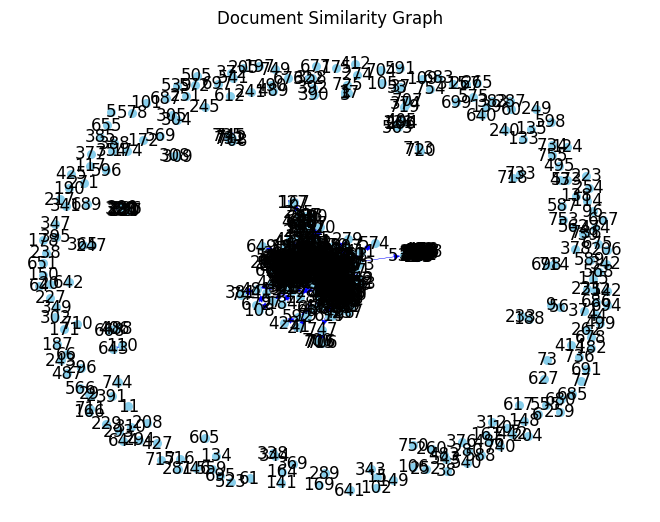

Resultado: {'graph': <networkx.classes.digraph.DiGraph object at 0x7f85e1c458d0>, 'similarity_matrix': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), 'number_of_nodes': 756, 'number_of_edges': 12518, 'edges_per_node': 16.558201058201057}


In [110]:
# Visualizar el grafo de similitud
graph_stats = visualizer.visualize_graph()

In [111]:
graph_stats

{'graph': <networkx.classes.digraph.DiGraph at 0x7f85e1c458d0>,
 'similarity_matrix': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'number_of_nodes': 756,
 'number_of_edges': 12518,
 'edges_per_node': 16.558201058201057}

In [92]:
df_PDF['title'].iloc[73]

'suscripción anual licencias aspose word for java y aspose pdf for java'

In [95]:
df_PDF['title'].iloc[11]

'mapa de la promoción económica en la ciudad de madrid. diseño de pdf descargable y de imágenes para difusión en redes y por mail, contrato basado del acuerdo marco de servicios de creación publicitaria declarada de gestión centralizada y de servicios de creación para las campañas institucionales de comunicación del ayuntamiento de madrid y sus organismos autónomos.'

In [102]:
df_PDF['title'].iloc[141]

'publicación impresa en papel y electrónica (pdf) que recopile la estrategia social de promoción de la salud de las illes balears: creación de imagen, diseño original y maquetación de la publicación; impresión (1.000 ejemplares) en papel en formato libro y edición electrónica (pdf).'

In [103]:
similarity_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)